In [1]:
from utility import *
from models import * 
from dataloader import *
my_module_path = os.path.join("../", '21cm-wrapper')
sys.path.append(my_module_path)
from Leaf import *

device = 'cpu'

#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism

CUDA is available:  True


In [2]:
# hyperparams
data_path = "/home/deck/Documents/masterstuff/data/datax5/"
batch_size = 32
epochs = 120
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=train_dataloader, Test_data=test_dataloader, device=device)

In [8]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.path + file)
/home/deck/Documents/masterstu

torch.Size([8, 6]) torch.Size([8, 1, 28, 28, 470])


/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Model.load_state_dict(torch.load(name, map_location=torch.dev

on 0: test_loss_density_net[-1]=1.0378567580605897 test_loss_summary_net[-1]=0.07897457732281214
|████████████████████████████████████████| 1 in 6:09.8 (0.00/s)                 
torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


Drawing 10000 posterior samples: 11122it [00:00, 18208.61it/s]                          


torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


Drawing 10000 posterior samples: 11234it [00:00, 16680.42it/s]                          


torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


Drawing 10000 posterior samples: 10942it [00:00, 17948.63it/s]                          


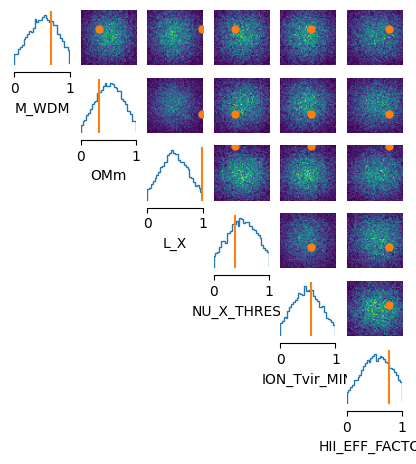

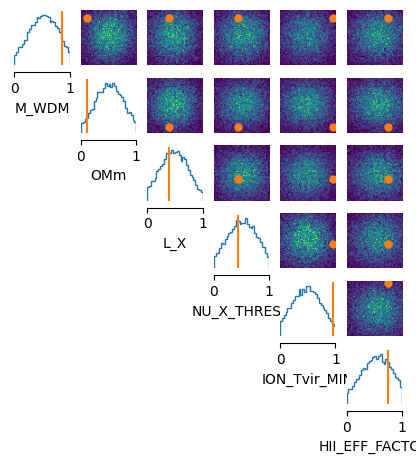

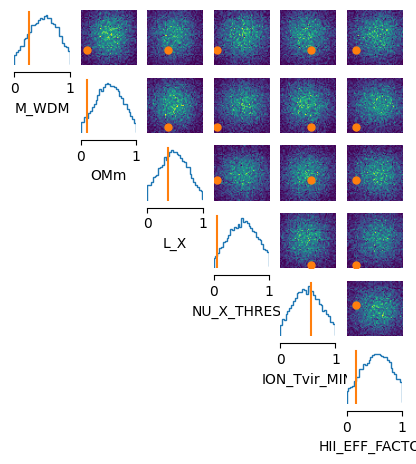

In [4]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net2.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none'
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=10,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NPE_{i}.png", dpi=300)

/home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`.

|████████████████████████████████████████| 1 in 21:15.1 (0.00/s)                
torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


/home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:114: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
Generating samples: 100%|██████████| 10200/10200 [03:45<00:00, 45.15it/s]


torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


Generating samples: 100%|██████████| 10200/10200 [03:22<00:00, 50.45it/s]


torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


Generating samples: 100%|██████████| 10200/10200 [03:21<00:00, 50.59it/s]


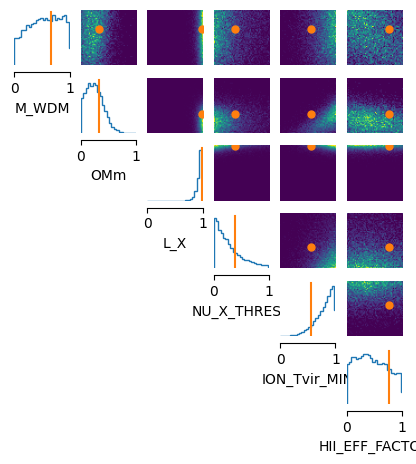

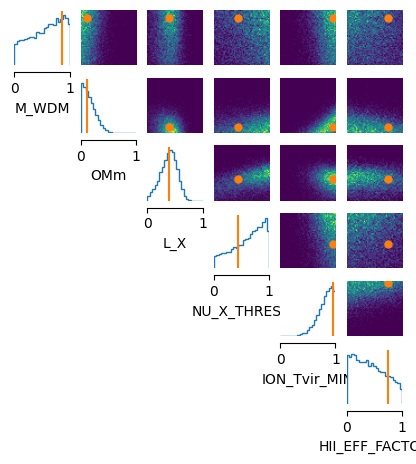

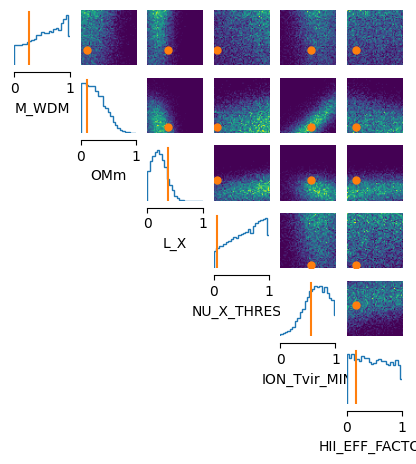

In [3]:
### NRE ###


from sbi.utils.get_nn_models import (
    classifier_nn
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNRE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net2.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
ratio_estimator = classifier_nn(
    model = 'resnet', z_score_x='none',  z_score_theta='none'
)

# train the maf
inference = SNRE(prior=prior, device=device, classifier=ratio_estimator)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]

density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=10,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

In [11]:
from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot

In [13]:
from sbi.utils.torchutils import repeat_rows
from torch import eye, ones
num_atoms=10

y,x,_ = test_dataloader.dataset.__getitem__(0)
y,x = y.unsqueeze(0), x.unsqueeze(0)
print(y.shape, x.shape)
x = model.Model(x)

y1, x1,_ = test_dataloader.dataset.__getitem__(1)
y1,x1 = y1.unsqueeze(0), x1.unsqueeze(0)
x1 = model.Model(x1)

y, x = torch.cat((y,y1)), torch.cat((x,x1))

batch_size = y.shape[0]
print(f'{batch_size=}')

repeated_x = repeat_rows(x, num_atoms)
print(f'{repeated_x=}')

# Choose `1` or `num_atoms - 1` thetas from the rest of the batch for each x.
probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
print(f'{probs=}')

choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)

/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.path + file)


torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])
batch_size=2
repeated_x=tensor([[0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.2040, 0.9926, 1.0000, 0.0059, 0.1586, 0.0331],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132],
        [0.8765, 0.2702, 0.3526, 0.2599, 0.7976, 0.0132

RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement

In [6]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

on 0: /home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8, 1, 6])) that is different to the input size (torch.Size([8, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
        return F.mse_loss(input, target, reduction=self.reduction)


|⚠︎                                       | (!) 0/120 [0%] in 2.5s (0.00/s)      


KeyboardInterrupt: 

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

loss: 9771.8095703125
 pred: tensor([[4.7056e+00, 2.0909e-01, 4.1509e+01, 9.7214e+02, 5.0531e+00, 1.9355e+02],
        [3.2670e+00, 3.0016e-01, 4.0285e+01, 2.0903e+02, 4.9114e+00, 2.1090e+02],
        [6.4987e+00, 3.5049e-01, 3.9270e+01, 7.9099e+02, 4.4319e+00, 2.7894e+01],
        [6.2723e+00, 2.3508e-01, 3.9357e+01, 1.3976e+02, 5.1864e+00, 1.0977e+02],
        [5.5044e+00, 2.2245e-01, 3.9430e+01, 9.9683e+02, 4.3380e+00, 7.5367e+01],
        [4.3802e+00, 3.3234e-01, 4.1685e+01, 1.1081e+03, 4.9861e+00, 9.9697e+01],
        [4.2998e+00, 2.6039e-01, 4.1193e+01, 9.4134e+02, 5.1101e+00, 1.4847e+02],
        [4.0433e+00, 2.7417e-01, 4.1350e+01, 1.1188e+03, 4.9679e+00, 1.9201e+02]])
 truth: tensor([[8.6254e+00, 2.0445e-01, 4.1475e+01, 1.0218e+03, 4.9343e+00, 2.0373e+02],
        [1.4387e+00, 2.5871e-01, 4.0479e+01, 1.9545e+02, 4.9306e+00, 2.0469e+02],
        [9.9281e+00, 3.7896e-01, 3.8860e+01, 1.2317e+03, 4.0699e+00, 2.0282e+01],
        [7.7567e+00, 2.4295e-01, 3.9419e+01, 2.9904e+02, 5.1

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

Set initial parameters...


In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

Drawing 5000 posterior samples: 5009it [00:03, 1262.64it/s]                          


|                                        | ▂▄▆ 0/5000 [0%] in 0s (~0s, 0.0/s) 

Process SpawnProcess-8:
Traceback (most recent call last):
Process SpawnProcess-9:
Traceback (most recent call last):
Process SpawnProcess-10:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args,

on 0: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x705fb3fc3240>


on 0: Traceback (most recent call last):
  File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()


on 0:   File "/home/potato/Documents/projects/master/ml-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)


on 0:   File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)


on 0:           ^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):


on 0:            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/multiprocessing/connection.py", line 935, in wait
    ready = selector.select(timeout)


on 0:             ^^^^^^^^^^^^^^^^^^^^^^^^


on 0:   File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)


on 0:                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


on 0: KeyboardInterrupt:


|⚠︎                                       | (!) 0/5000 [0%] in 8.2s (0.00/s)     


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

|                                        | ▁▃▅ 0/68 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 68/68 [100%] in 3.6s (19.17/s)       
 Training neural network. Epochs trained: 27

|████████████████████████████████████████| 4/4 [100%] in 0.4s (8.11/s)          




Generating 10 MCMC inits with 10

Generating 10 MCMC inits with 10
                         workers.: 100%|██████████| 10/10 [00:00<00:00, 52.34it/s]


















































































































































































































































































































































































































































































































































































































































































































































































































































































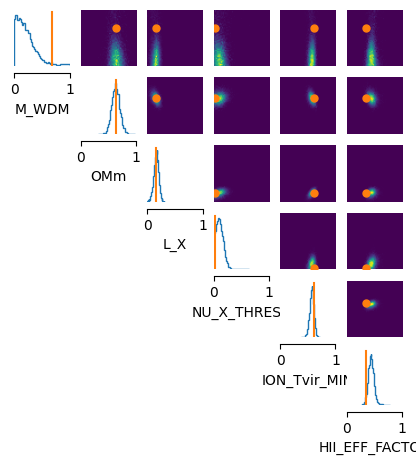

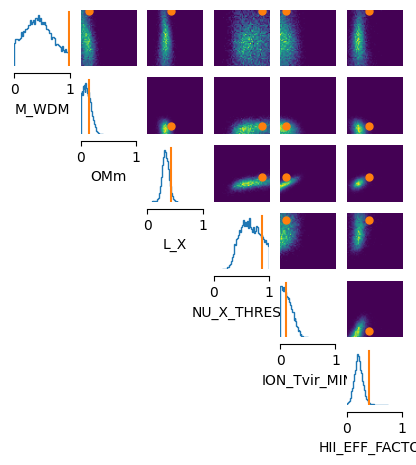

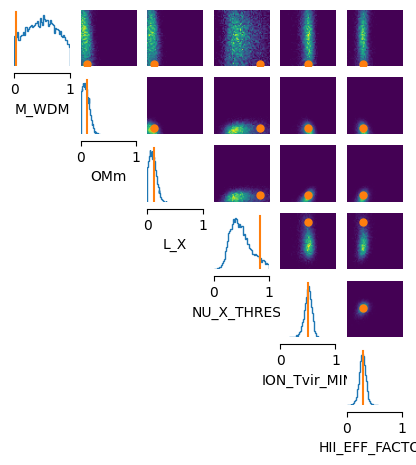

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

torch.Size([1, 1, 40, 40, 600])


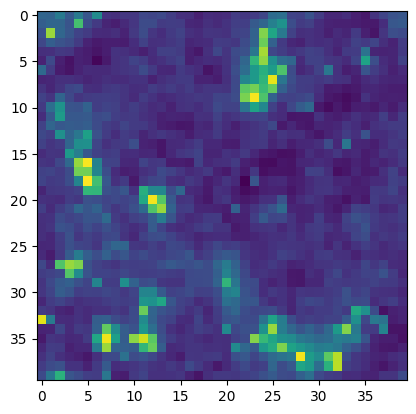

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

19 ms ± 223 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test = 0 if 0 == 1 elif

tensor([[5.9217e+00, 2.7670e-01, 3.8726e+01, 1.2436e+03, 4.0089e+00, 1.0010e+02],
        [4.2041e+00, 2.6606e-01, 3.9172e+01, 1.4720e+03, 5.0995e+00, 1.9095e+02],
        [4.7895e+00, 3.0926e-01, 4.0212e+01, 1.5779e+02, 4.8395e+00, 2.4750e+02],
        [3.5780e+00, 1.9815e-01, 3.8804e+01, 1.3745e+03, 4.3869e+00, 1.4221e+02],
        [7.3720e+00, 2.2123e-01, 3.9222e+01, 1.3777e+03, 4.2282e+00, 9.7412e+01],
        [9.8951e+00, 2.8068e-01, 3.9821e+01, 1.0525e+03, 4.3870e+00, 1.4162e+02],
        [6.2702e+00, 3.7933e-01, 3.9238e+01, 1.3620e+03, 5.2352e+00, 7.8885e+01],
        [4.0333e+00, 3.2795e-01, 3.8614e+01, 3.5615e+02, 4.7485e+00, 2.2162e+02],
        [6.2316e+00, 2.6243e-01, 3.9077e+01, 1.4615e+03, 4.6586e+00, 9.4448e+01],
        [8.8193e-01, 3.9259e-01, 4.1729e+01, 4.1617e+02, 4.9176e+00, 1.3069e+02],
        [6.5229e+00, 3.7412e-01, 4.0628e+01, 1.0993e+02, 4.7226e+00, 2.2049e+02],
        [5.1963e-01, 3.7171e-01, 3.9748e+01, 5.6189e+02, 4.8741e+00, 1.5590e+02],
        [8.4533e

In [17]:
from sbi import utils, analysis

from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot
import corner
import numpy as np
import arviz
import pickle
from sbi.inference.posteriors import MCMCPosterior

In [21]:
with open("../NRE_de.pkl", "rb") as handle:
    posterior = pickle.load(handle)

posterior.potential_fn.device = 'cpu'
posterior = MCMCPosterior(potential_fn=posterior.potential_fn,
                          proposal=posterior.proposal,
                          theta_transform=posterior.theta_transform,
                          method='slice_np_vectorized',
                          thin=posterior.thin,
                          warmup_steps=posterior.warmup_steps,
                          num_chains=6,
                          num_workers=6,
                          device='cpu')

model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("../NRE_sn.pt")
sum_net = model.Model

with torch.no_grad():
    with alive_bar(len(test_dataloader), force_tty=True, refresh_secs=1) as bar:
        for i, (lab, img,_) in enumerate(test_dataloader):
            img, lab = img.to(device), lab.to(device)
            
            if not i:
                summary_vec = torch.empty(0,lab.shape[1], device=device)
                labels = torch.empty(0,lab.shape[1], device=device)

            pred = sum_net(img)
            summary_vec = torch.cat((summary_vec, pred), dim=0)
            labels = torch.cat((labels, lab), dim=0)
            bar()

xs = summary_vec
thetas = labels
num_sbc_runs = xs.shape[0]
num_posterior_samples = num_sbc_runs

#xs, thetas = model.full_inference(sbc_dataloader)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

fig, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
    parameter_labels = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],
)

fig.savefig("NRE_sbc_rank_maf_freezed_sum.png", dpi=300)

fig, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=[r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],)
fig.savefig("NRE_sbc_CDF_maf_freezed_sum.png", dpi=300)

/home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/h

on 0: /home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
        data = torch.load(self.path + file)
on 0: /home/deck/D

|████████████████████████████████████████| 35/35 [100%] in 39.1s (0.91/s)       


Running 1120 sbc samples.:   0%|          | 0/1120 [00:00<?, ?it/s]/home/deck/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 

RuntimeError: HIP error: invalid device function
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing AMD_SERIALIZE_KERNEL=3
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


In [25]:
posterior.potential_fn

Signature:      posterior.potential_fn(theta: torch.Tensor, track_gradients: bool = True) -> torch.Tensor
Type:           RatioBasedPotential
String form:    <sbi.inference.potentials.ratio_based_potential.RatioBasedPotential object at 0x7fd7eeed1450>
File:           ~/Documents/masterstuff/ml-venv/lib/python3.11/site-packages/sbi/inference/potentials/ratio_based_potential.py
Docstring:      <no docstring>
Init docstring:
Returns the potential for ratio-based methods.

Args:
    ratio_estimator: The neural network modelling likelihood-to-evidence ratio.
    prior: The prior distribution.
    x_o: The observed data at which to evaluate the likelihood-to-evidence
        ratio.

Returns:
    The potential function.
Call docstring:
Returns the potential for likelihood-ratio-based methods.

Args:
    theta: The parameter set at which to evaluate the potential function.
    track_gradients: Whether to track the gradients.

Returns:
    The potential.

In [4]:
for x,y,_ in train_dataloader:
    print(x.shape, y.shape)
    breal

/home/deck/Documents/masterstuff/21cm-sbi/dataloader.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.path + file)
/home/deck/Documents/masterstu

torch.Size([8, 6]) torch.Size([8, 28, 28, 470])


NameError: name 'breal' is not defined

In [ ]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)


# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))